# Categorização de avaliações

**Passo a passo:**

1. **Pré-processamento**: Remover stop words e aplicar stemming ou lematização
    - Stemming: reduz palavras ao seu radical, ignorando as regras linguísticas (é útil para reduzir a dimensionalidade)
    - Lematização: Reduz palavras à sua forma básica, considerando o contexto gramatical (é mais precisa)
2. **Extração de Características**: Usar TF-IDF ou Word2Vec para criar representações vetoriais das avaliações
    - TF-IDF (term frequence - inverse document frequency) calcula a relevância de cada termo dentro de um documento
    - O Word2Vec captura relações semânticas entre as palavras, criando representações vetoriais densas, que são úteis para capturar o contexto semântico (no entanto, demanda mais recursos computacionais)
3. **Clusterização**: Aplicar K-means para definir categorias com base nas avaliações
    - Após definir os clusters, as categorias podem ser interpretadas extraindo as palavras mais representativas de cada cluster
    - No TF-IDF, isso é feito analisando os pesos de cada termo em cada clsuter
4. **Classificação**: Usar o modelo para categorizar novas avaliações de acordo com as categorias definidas
5. **Avaliação e Ajuste**: Medir a precisão e otimizar o pipeline

## 1. Imports

In [45]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import nltk
from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer

import gensim
from gensim.models import Word2Vec

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [3]:
# baixar stopwords e pacotes do nltk
# punkt sequence tokenizer = divide um texto em uma lista de sentenças usando um algoritmo não supervisionado para construir um modelo para abreviação de palavras

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [4]:
# criar stopwords
stop_words = set(stopwords.words('portuguese'))
len(stop_words)

207

In [5]:
# função para stemming
stemmer = nltk.stem.RSLPStemmer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(tokens)

## 2 Ler base de dados e fazer pre-tratamento

In [6]:
# ler base
df = pd.read_csv('dados/bares_maps/bd-reviews_Reworked.csv')

# remover dicionários vazios
df = df[df['reviews'].notna()]

# extrair nome e comentário do json da coluna de texto
df['name'] = df['reviews'].apply(lambda x: eval(x)['name'])
df['comentario'] = df['reviews'].apply(lambda x: eval(x)['text'])

# selecionar colunas importantes
df = df[['title', 'price', 'categoryName', 'totalScore', 'reviewsCount', 'name', 'comentario']]

# remover os comentários que estão vazios
df = df[df['comentario'].notna()]

# fazer pre-tratamento (remover caracteres especiais e colocar em minúsculo)
df['comentario_tratado'] = df['comentario'].apply(lambda x: re.sub('[^A-Za-z0-9áéíóúàèìòùãõñçâêô ]+', '', x.lower()))

# criar coluna de tamanho do texto
df['tamanho_comentario'] = df['comentario_tratado'].apply(lambda x: len(x))

# aplicar o stemming
df['preprocessed_text'] = df['comentario_tratado'].apply(preprocess_text)
df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,comentario_tratado,tamanho_comentario,preprocessed_text
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...


## 3 Vetorização

### 3.1 TF-IDF

In [7]:
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, max_features = 1000)
X_tfidf = vectorizer.fit_transform(df['preprocessed_text'])

# ver a matriz criada
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
X_tfidf_df.head()

,abert,abr,abraç,absurd,acab,aceit,acess,ach,acim,acolh,...,wellington,zer,ágil,águ,álcool,áre,óle,ótim,últ,únic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183539,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143118,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### 3.2 Word2Vec

In [8]:
tokenized_reviews = df['preprocessed_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences = tokenized_reviews, vector_size = 100, window = 5, min_count = 2, sg = 1)

def get_average_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis = 0) if vectors else np.zeros(100)

df['word2vec_vector'] = df['preprocessed_text'].apply(lambda x: get_average_word2vec(x.split(), word2vec_model))
X_word2vec = np.vstack(df['word2vec_vector'].values)
df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[0.0051352438, 0.08788412, -0.044132873, -0.10..."
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.042578258, 0.04112141, -0.043186244, -0.086..."
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...,"[-0.02065424, 0.095827654, -1.5927106e-05, -0...."
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...,"[-0.005348485, -0.007019118, -0.02178417, -0.0..."
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...,"[-0.01165949, 0.05511513, -0.0115294885, -0.07..."


## 4. Clusterização para a criação de categorias

### 4.1 Elbow method para determinação do número de clusters

Roda o K-means com diferentes quantidades de clusters (k) e plota a soma das distâncias quadradas internas (inertia) para cada valor de k

O "cotovelo" indica o número ideal de clusters (com mais clusters, a inertia não diminui tanto se comparado ao k do cotovelo)

In [9]:
def plot_elbow_method(X, max_k = 10, title = "Elbow Method"):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize = (16, 5))
    plt.plot(range(1, max_k + 1), inertias, marker = 'o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(title)

    # Configura o range do eixo y
    plt.ylim(min(inertias) - 1000, max(inertias) + 1000)

    # Configura o eixo x para ir de 1 em 1
    plt.xticks(range(1, max_k + 1, 1))

    plt.show()

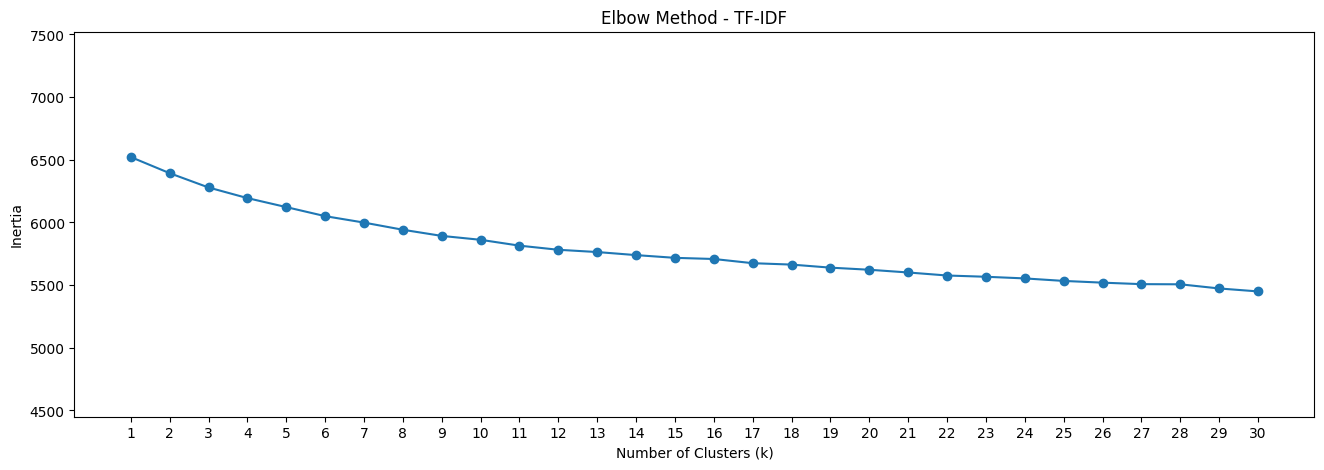

In [10]:
# Para TF-IDF
plot_elbow_method(X_tfidf, max_k = 30, title = "Elbow Method - TF-IDF")

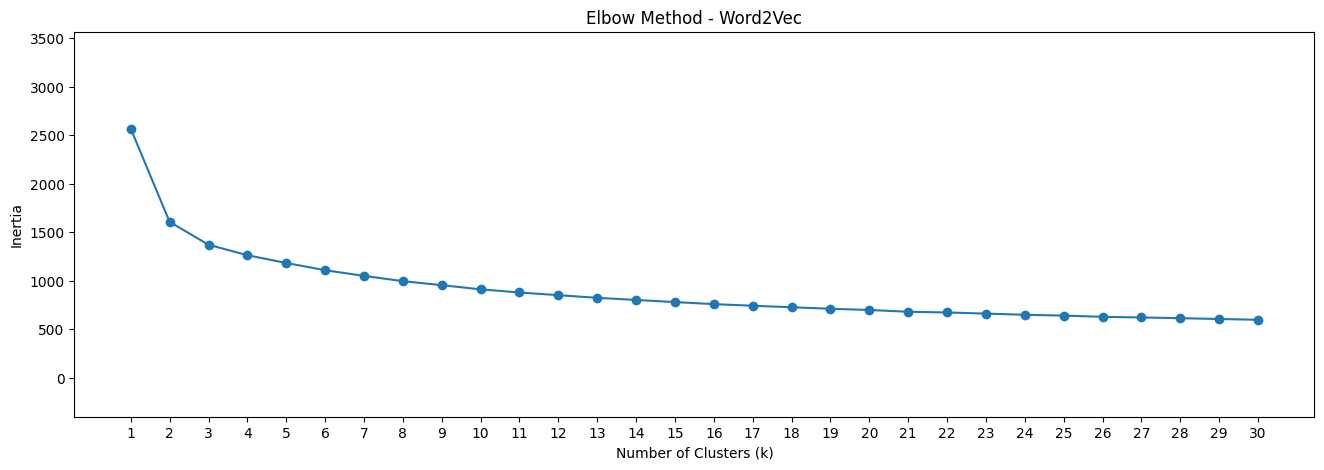

In [11]:
# Para Word2Vec
plot_elbow_method(X_word2vec, max_k = 30, title = "Elbow Method - Word2Vec")

### 4.3 Silhouette score

É a média do Silhouette Coefficient de todas as amostras.

O Silhouette Coefficient de uma amostra é calculado da seguinte forma:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$

Onde:
- `a(i)` é a distância média entre o ponto `i` e todos os outros pontos do mesmo cluster (cohesão)
- `b(i)` é a distância média entre o ponto `i` e todos os pontos do cluster mais próximo (separação)

Varia entre -1 (pior valor) e 1 (melhor valor).
- Valores próximos a 0 indicam que os clusters se sobrepõem
- Valores negativos indicam que uma amostra foi atribuida a um cluster errado (um cluster diferente é mais similar)

In [40]:
def plot_silhouette_scores(X, max_k = 10, title = "Elbow Method"):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit_predict(X)
        # print(silhouette_score(X, kmeans.labels_))
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    plt.figure(figsize = (16, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker = 'o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title(title)

    # Configura o range do eixo y
    plt.ylim(min(silhouette_scores) - 0.1, max(silhouette_scores) + 0.1)

    # Configura o eixo x para ir de 1 em 1
    plt.xticks(range(1, max_k + 1, 1))

    plt.show()

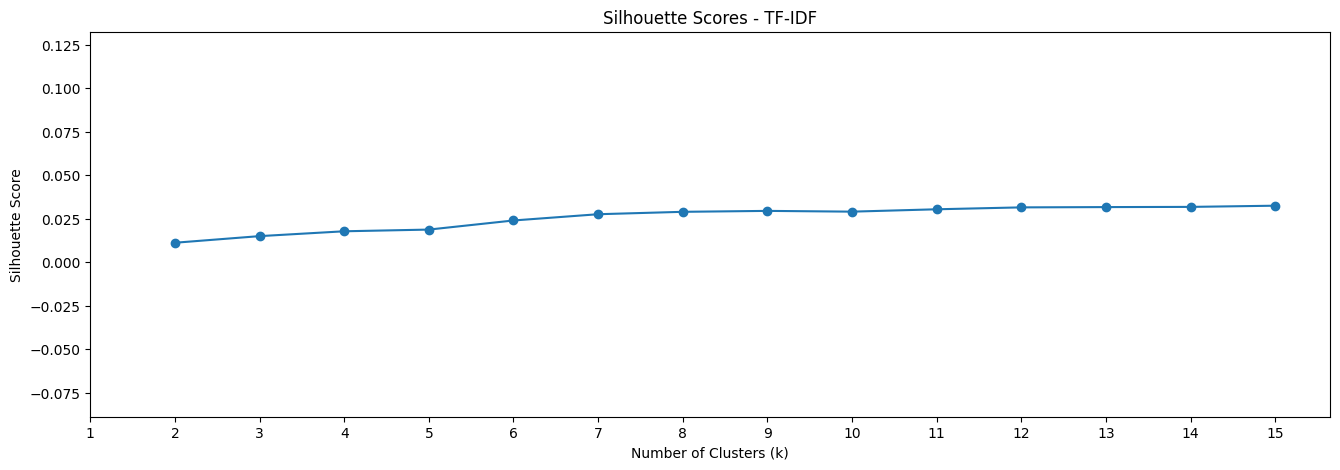

In [41]:
# Para TF-IDF
plot_silhouette_scores(X_tfidf, max_k = 15, title = "Silhouette Scores - TF-IDF")

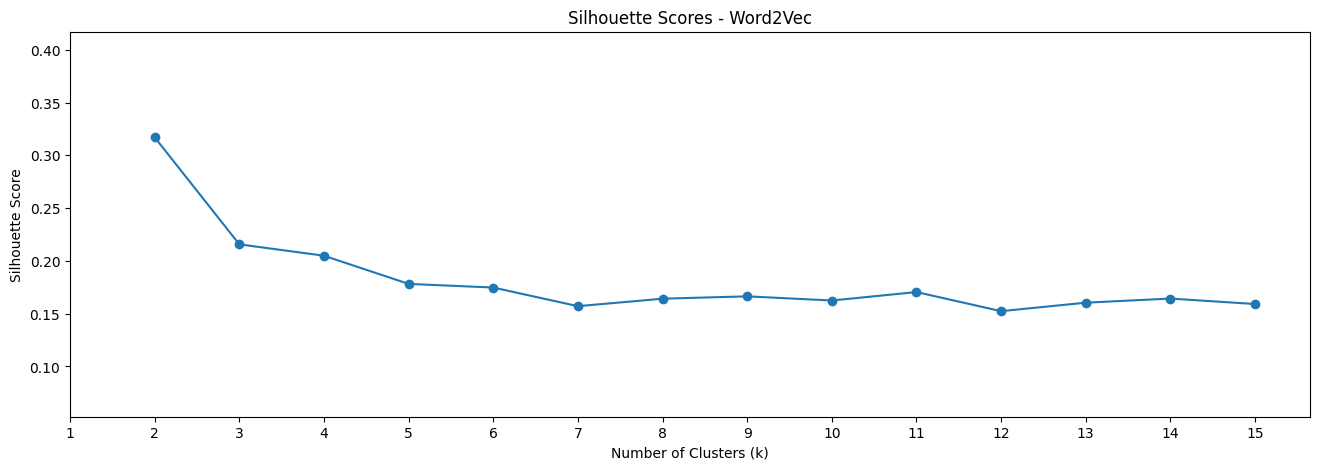

In [42]:
# Para Word2Vec
plot_silhouette_scores(X_word2vec, max_k = 15, title = "Silhouette Scores - Word2Vec")

### 4.2 Aplicar k-means

In [111]:
n_clusters_tfidf = 9
n_clusters_word2vec = 5

In [112]:
kmeans_tfidf = KMeans(n_clusters = n_clusters_tfidf, random_state = 42)
df['cluster_tfidf'] = kmeans_tfidf.fit_predict(X_tfidf)

kmeans_word2vec = KMeans(n_clusters = n_clusters_word2vec, random_state = 42)
df['cluster_word2vec'] = kmeans_word2vec.fit_predict(X_word2vec)

df.head()

,title,price,categoryName,totalScore,reviewsCount,name,comentario,comentario_tratado,tamanho_comentario,preprocessed_text,word2vec_vector,cluster_tfidf,cluster_word2vec
0,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Flavia Bruno,"Comida boa, apesar de ser a peso. A mesa de sa...",comida boa apesar de ser a peso a mesa de sala...,257,com boa apes pes mes sal falt rep com sabor em...,"[0.0051352438, 0.08788412, -0.044132873, -0.10...",7,0
1,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Cristiane B Monteiro,Gosto demais da variedade da comida. Não tem c...,gosto demais da variedade da comida não tem ch...,163,gost demal variedad com churrasc outr carn boa...,"[0.042578258, 0.04112141, -0.043186244, -0.086...",7,4
2,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Joao Laurindo Duarte,"O restaurante vende refeição por quilo, cheque...",o restaurante vende refeição por quilo chequei...,171,restaurant vend refe quil cheq hor fim dev fec...,"[-0.02065424, 0.095827654, -1.5927106e-05, -0....",7,0
3,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Mayannah Hingstone,Ótima opção para almoço no setor Jaó. Grande v...,ótima opção para almoço no setor jaó grande va...,194,ótim opç almoç set jaó grand variedad com opç ...,"[-0.005348485, -0.007019118, -0.02178417, -0.0...",7,4
4,Cajueiro Bar & Restaurante,$$,Self service restaurant,4.7,727,Deyvid Linhares,Atendimento excelente!\nComida e preço muito b...,atendimento excelentecomida e preço muito bom ...,100,atend excelentecom preç bom fic pes gram torn ...,"[-0.01165949, 0.05511513, -0.0115294885, -0.07...",7,0


### 4.3 Palavra mais comum de cada cluster

In [113]:
def nomes_clusters(coluna):

    most_common_words = {}

    for cluster in df[coluna].unique():
        texts_in_cluster = df[df[coluna] == cluster]['preprocessed_text']
        words = " ".join(texts_in_cluster).split()
        word_counts = Counter(words)
        most_common_word = word_counts.most_common(1)[0]
        most_common_words[cluster] = most_common_word

    tmp = df[coluna].value_counts().reset_index()
    tmp['palavra_mais_comum'] = tmp[coluna].map(most_common_words).apply(lambda x: x[0])
    tmp = tmp[[coluna, 'palavra_mais_comum', 'count']]

    return tmp

In [114]:
print(f'Silhouette Score TF-IDF: {round(silhouette_score(X_tfidf, kmeans_tfidf.labels_), 5)}')
nomes_clusters(coluna = 'cluster_tfidf')

Silhouette Score TF-IDF: 0.02941


,cluster_tfidf,palavra_mais_comum,count
0,7,atend,3613
1,2,cervej,561
2,6,excel,522
3,5,melhor,501
4,4,agrad,467
5,0,ótim,431
6,3,maravilh,345
7,8,bom,239
8,1,top,186


In [115]:
print(f'Silhouette Score Word2Vec: {round(silhouette_score(X_word2vec, kmeans_word2vec.labels_), 5)}')
nomes_clusters(coluna = 'cluster_word2vec')

Silhouette Score Word2Vec: 0.17819


,cluster_word2vec,palavra_mais_comum,count
0,3,atend,1839
1,0,atend,1479
2,1,com,1433
3,2,ambi,1209
4,4,com,905


### 4.3 Visualização dos clusters

In [116]:
def pca_plot(metodo):

    print(f"Silhouette Score {metodo}: {round(silhouette_score(eval(f'X_{metodo}'), eval(f'kmeans_{metodo}').labels_), 5)}")

    # Número de clusters
    num_clusters = eval(f'n_clusters_{metodo}')

    # Reduzindo a dimensionalidade para 2D com PCA
    pca = PCA(n_components = 2, random_state = 42)

    if type(eval(f'X_{metodo}')) == np.ndarray:
        X_array = eval(f'X_{metodo}')
    else:
        X_array = eval(f'X_{metodo}').toarray()
    
    X_2d = pca.fit_transform(X_array)

    # Aplicando o KMeans e pegando as previsões
    kmeans_pca = eval(f'kmeans_{metodo}')
    clusters = kmeans_pca.fit_predict(eval(f'X_{metodo}'))

    # Plotando o scatter plot
    plt.figure(figsize = (10, 7))
    for cluster in range(num_clusters):
        # Filtrando os pontos de cada cluster
        plt.scatter(X_2d[clusters == cluster, 0], X_2d[clusters == cluster, 1],
                    label=f"Cluster {cluster}", alpha=0.6)

    # Plotando os centróides
    centroids_2d = pca.transform(kmeans_pca.cluster_centers_)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s = 100, c = 'black', marker = 'X', label = "Centroids")

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.title(f"Clusters ({metodo.capitalize()})")
    plt.show()

Silhouette Score tfidf: 0.02941


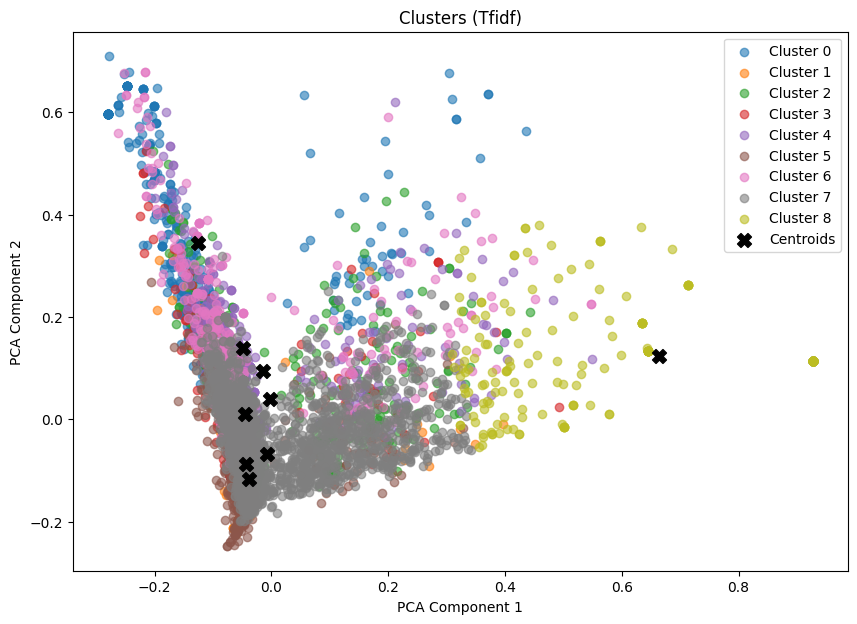

In [117]:
pca_plot(metodo = 'tfidf')

Silhouette Score word2vec: 0.17819


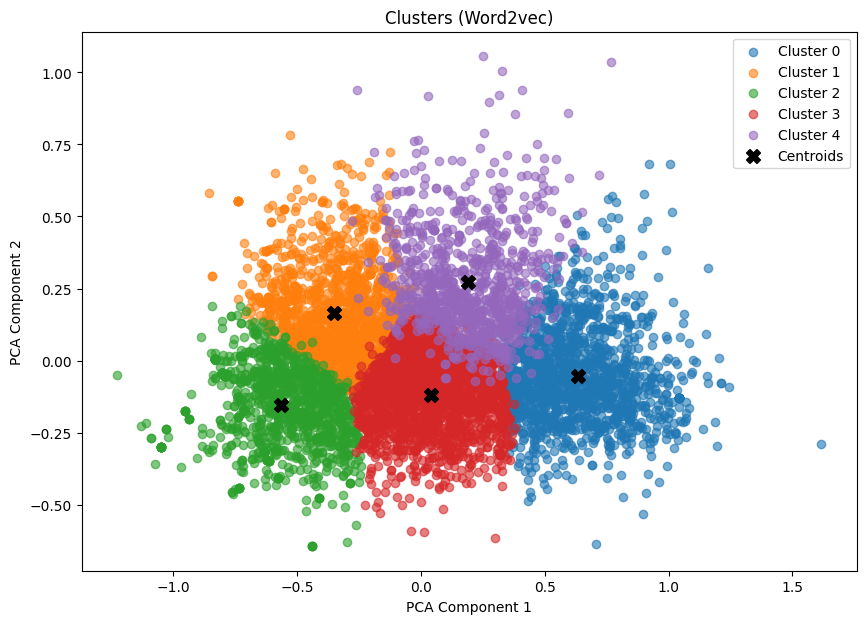

In [118]:
pca_plot(metodo = 'word2vec')

## 5. Classificação de uma nova avaliação
Exemplo de nova avaliação:

In [24]:
new_review = "Avaliação de exemplo"
preprocessed_review = preprocess_text(new_review)
review_vector = vectorizer.transform([preprocessed_review])

# Prever o cluster
predicted_cluster = kmeans.predict(review_vector)
predicted_cluster